<a href="https://colab.research.google.com/github/VincentCCL/MTAT/blob/main/MTAT26_RNN_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Machine Translation with RNN

In chapter 4 we built a recurrent language model (RNN-LM) that predicts the next word in a
sentence given all previous words. Neural machine translation (NMT) with an encoder–decoder
RNN introduces only one essential new idea:
* An encoder RNN reads the source sentence (e.g. English) and summarises it in its final hidden state.
* A decoder RNN is simply a conditional language model : it generates the target sentence (e.g. Dutch), one word at a time, starting from the encoder's final state.

Architecturally, the decoder behaves just like our RNN language model: it takes previous target words as input and predicts the next one. The only new element is that its initial hidden state comes from the encoder instead of being a fixed vector.

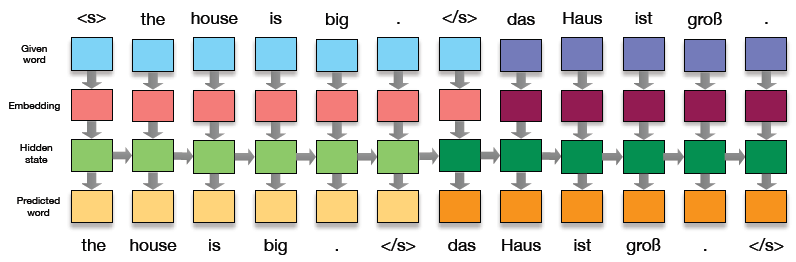

Figure 5.1: Sequence-to-sequence encoder-decoder model: Extending the language model, we concatenate the English input sentence `the house is big` with the German output sentence `das Haus ist groß`. The first dark green box (after processing the end-of-sentence token </s>) contains the embedding of the entire input sentence. Figure from Koehn (2020).

##Implementation: Toy Examples
To keep things transparent, we re-use the small toy corpus and add Dutch translations. Each English sentence has a Dutch counterpart.

In [ ]:
src_raw = [
"i am a student",
"i am a teacher",
"you are a student",
"you are a teacher",
"she is a student",
"he is a teacher",
"we are students",
"they are teachers",
"i like apples",
"you like apples",
"she likes apples",
"he likes apples",
]
tgt_raw = [
"ik ben een student",
"ik ben een leraar",
"jij bent een student",
"jij bent een leraar",
"zij is een student",
"hij is een leraar",
"wij zijn studenten",
"zij zijn leraren",
"ik lust appels",
"jij lust appels",
"zij lust appels",
"hij lust appels",
]

As before, this dataset is far too small for any serious translation, but it is ideal for illustrating the mechanics of encoder–decoder training.

We largely repeat what we did for the language model, but now we have two languages.

## Preprocessing steps



### Adding `<sos>` and `<eos>`

We start by importing the Keras preprocessing utilities and adding explicit start/end markers to every sentence on both sides

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Add <sos> and <eos> on both sides
src = [f"<sos> {s} <eos>" for s in src_raw]
tgt = [f"<sos> {s} <eos>" for s in tgt_raw]
print("Example source with markers:", src[0])
print("Example target with markers:", tgt[0])

Example source with markers: <sos> i am a student <eos>
Example target with markers: <sos> ik ben een student <eos>



These markers play the same role as in the language model: they tell the model where sentences begin and end.

###Tokenisers and Integer Sequences

We now build two tokenisers: one for the English source, one for the Dutch target. We then convert sentences into sequences of integer IDs.

In [ ]:
# Separate tokenisers for source (English) and target (Dutch)
tokenizer_src = Tokenizer(filters="", lower=True)
tokenizer_tgt = Tokenizer(filters="", lower=True)
tokenizer_src.fit_on_texts(src)
tokenizer_tgt.fit_on_texts(tgt)
src_sequences = tokenizer_src.texts_to_sequences(src)
tgt_sequences = tokenizer_tgt.texts_to_sequences(tgt)
print("First source sequence:", src_sequences[0])
print("First target sequence:", tgt_sequences[0])

First source sequence: [1, 6, 10, 3, 7, 2]
First target sequence: [1, 6, 11, 3, 7, 2]


Here, each integer refers to a word in a word-index dictionary such as

tokenizer_tgt.word_index (e.g. `"ik" -> 6`, `"student" -> 7`).

In [ ]:
tokenizer_src.index_word

{1: '<sos>',
 2: '<eos>',
 3: 'a',
 4: 'are',
 5: 'apples',
 6: 'i',
 7: 'student',
 8: 'teacher',
 9: 'you',
 10: 'am',
 11: 'she',
 12: 'is',
 13: 'he',
 14: 'like',
 15: 'likes',
 16: 'we',
 17: 'students',
 18: 'they',
 19: 'teachers'}

In [ ]:
tokenizer_tgt.index_word

{1: '<sos>',
 2: '<eos>',
 3: 'een',
 4: 'lust',
 5: 'appels',
 6: 'ik',
 7: 'student',
 8: 'leraar',
 9: 'jij',
 10: 'zij',
 11: 'ben',
 12: 'bent',
 13: 'is',
 14: 'hij',
 15: 'zijn',
 16: 'wij',
 17: 'studenten',
 18: 'leraren'}

###Vocabulary Sizes and Maximum Lengths

As before, we add 1 to the vocabulary sizes to reserve index 0 for padding. We also compute the maximum sentence length on each side

In [ ]:
# Vocabulary sizes (+1 for padding index 0)
num_src_tokens = len(tokenizer_src.word_index) + 1
num_tgt_tokens = len(tokenizer_tgt.word_index) + 1

# Maximum lengths
max_src_len = max(len(seq) for seq in src_sequences)
max_tgt_len = max(len(seq) for seq in tgt_sequences)

print("num_src_tokens:", num_src_tokens)
print("num_tgt_tokens:", num_tgt_tokens)
print("max_src_len:", max_src_len)
print("max_tgt_len:", max_tgt_len)

num_src_tokens: 20
num_tgt_tokens: 19
max_src_len: 6
max_tgt_len: 6


This tells us how large the embedding layers must be and how many time steps the encoder and decoder will process.

Each embedding layer needs to know how many possible token IDs exist so it can create a lookup table of the right size.

Concretely:
* The source embedding layer must have shape
`Embedding(input_dim=num_src_tokens, output_dim=embed_dim)`. If `num_src_tokens = 20`, then the embedding layer is a table with 20 rows, one vector per word.
* The target embedding layer must have shape
`Embedding(input_dim=num_tgt_tokens,output_dim=embed_dim)`. If `num_tgt_tokens = 19`, the decoder embedding layer is a table with 19 rows.

`embed_dim` is the number of embedding dimensions, a hyperparameter which we can choose.

###Padding to Fixed Length

Neural networks operate on rectangular batches, so we pad all sequences on both sides to a fixed length using zeros (the padding ID). We use post-padding again, i.e. zeros are added at the end of shorter sentences.

In [ ]:
# Pad with zeros on the right (post-padding)
src_sequences_padded = pad_sequences(
    src_sequences, maxlen=max_src_len, padding="post"
)
tgt_sequences_padded = pad_sequences(
    tgt_sequences, maxlen=max_tgt_len, padding="post"
)

print("encoder input shape:", src_sequences_padded.shape)
print("full target shape:", tgt_sequences_padded.shape)
print("Example padded source:", src_sequences_padded[0])
print("Example padded target:", tgt_sequences_padded[0])

encoder input shape: (12, 6)
full target shape: (12, 6)
Example padded source: [ 1  6 10  3  7  2]
Example padded target: [ 1  6 11  3  7  2]


In [ ]:
src_sequences_padded

array([[ 1,  6, 10,  3,  7,  2],
       [ 1,  6, 10,  3,  8,  2],
       [ 1,  9,  4,  3,  7,  2],
       [ 1,  9,  4,  3,  8,  2],
       [ 1, 11, 12,  3,  7,  2],
       [ 1, 13, 12,  3,  8,  2],
       [ 1, 16,  4, 17,  2,  0],
       [ 1, 18,  4, 19,  2,  0],
       [ 1,  6, 14,  5,  2,  0],
       [ 1,  9, 14,  5,  2,  0],
       [ 1, 11, 15,  5,  2,  0],
       [ 1, 13, 15,  5,  2,  0]], dtype=int32)

For instance, if the first source sentence has length 6 and our `max_src_len` is also 6, no padding is needed. Shorter sentences will have zeros appended until they reach length 6.

###Shifted Decoder Inputs and Targets

>**Teacher Forcing**
>When training the decoder of an encoder–decoder model, we must decide what input the decoder should receive at each time step. Recall that the decoder is a conditional language model: at every position it predicts the next target word.
> There are two possibilities:
> 1. Option 1: Let the decoder feed itself (no teacher forcing).
>   We could let the decoder use its own predictions as input at the next step. For
example:
> *Start with <sos>.
> * Predict a word (e.g. ik).
> * Feed that prediction back in.
> * Predict the next word, and so on.

>This works during inference, but during training it causes problems: early mistakes
propagate. If the model predicts hij instead of ik for the first word, then the correct second word ben no longer fits the context. The model ends up learning from its own errors.
> 2. Option 2: Use teacher forcing (standard in NMT training).
>   Instead of feeding the model’s predictions back into the decoder, we feed the correct previous target word at each time step. This stabilises training and allows the model to learn grammatical patterns much more quickly.


To use teacher forcing we split each padded target
sequence into two shifted versions:

`decoder_input_data = [w0, w1, w2, . . . , wT −1],
decoder_target_data = [w1, w2, w3, . . . , wT ].`

In other words:
* the decoder input sequence drops the final token;
* the decoder target sequence drops the first token.

This ensures that at every time step the decoder learns to predict the next word in the sentence, exactly like the recurrent language model from the previous section.


In [ ]:
# Decoder input / output for teacher forcing:
#   decoder_input_data:  <sos> ik ben een student
#   decoder_target_data: ik ben een student <eos>
decoder_input_data = tgt_sequences_padded[:, :-1]
decoder_target_data = tgt_sequences_padded[:, 1:]

print("decoder input shape:", decoder_input_data.shape)
print("decoder target shape:", decoder_target_data.shape)
print("decoder_input_data[0]:", decoder_input_data[0])
print("decoder_target_data[0]:", decoder_target_data[0])

decoder input shape: (12, 5)
decoder target shape: (12, 5)
decoder_input_data[0]: [ 1  6 11  3  7]
decoder_target_data[0]: [ 6 11  3  7  2]


So at each position the decoder sees the number of the previous word and learns to predict the next one, exactly as in the RNN language model.

###Convenience Dictionaries for Decoding

As a final preprocessing step, we store some helper structures for use during generation: the target word-index mapping and the special IDs for `<sos>` and `<eos>`

In [ ]:
# Convenience dictionaries for later decoding
tgt_word_index = tokenizer_tgt.word_index
tgt_index_word = {i: w for w, i in tgt_word_index.items()}

eos_id = tgt_word_index["<eos>"]
sos_id = tgt_word_index["<sos>"]

print("sos_id:", sos_id, "->", tgt_index_word[sos_id])
print("eos_id:", eos_id, "->", tgt_index_word[eos_id])

sos_id: 1 -> <sos>
eos_id: 2 -> <eos>


These variables will be used later in the inference code to start decoding with `<sos>` and to stop when `<eos>` is generated.

Up to this point, the pipeline is almost identical to the language modelling setup, except that we now have two tokenisers and we split the target into decoder inputs and decoder targets.

##Building and Training the Encoder--Decoder Model
After preprocessing the data (Steps 1–6), we now construct the full encoder–decoder architecture.
This section mirrors the design of the first generation of neural machine translation systems (Cho et al. 2014; Sutskever et al. 2014): an encoder RNN compresses the source sentence into a fixed-size vector, and a decoder RNN generates the target sentence one word at a time, using teacher
forcing during training.

###Building the Encoder
The encoder reads the padded source sentence and produces a single hidden state representing its meaning. Unlike the decoder, the encoder does not produce words; its task is to understand the input sentence as a whole.

The steps in the code are explained in the comment lines within the code

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
# These lines import the libraries used to build the model. keras and layers provide building
# blocks such as input layers, embedding layers, and recurrent layers. (numpy is a standard library
# for numerical data and is often used for preprocessing.

embed_dim = 64
hidden_size = 128
# Here we set two important sizes:
# • embed_dim: how many numbers we use to represent each word (a word embedding).
# • hidden_size: how large the encoder’s internal memory is while reading a sentence.
# Larger values can capture more information, but also make the model slower and more prone to
# overfitting if the dataset is small

# 1) The encoder input
encoder_inputs = keras.Input(
    shape=(max_src_len,), dtype="int32", name="encoder_inputs"
)
# This defines what the encoder receives as input: a sequence of integers (word IDs), with one
# integer per word position.
# • max_src_len is the maximum source sentence length we allow.
# • Each sentence shorter than this is padded with a special padding symbol.
# So the encoder always receives a sentence in a fixed-length format, even though real sentences
# can be shorter.

# 2) Turning word IDs into embeddings
encoder_embedding = layers.Embedding(
    input_dim=num_src_tokens,
    output_dim=embed_dim,
    mask_zero=True,
    name="encoder_embedding",
)
# This creates an embedding layer for the source language.
# • input_dim=num_src_tokens: the size of the source vocabulary (how many different source
# tokens we know).
# • output_dim=embed_dim: each token is represented as a list of embed_dim numbers.
# • mask_zero=True: the token ID 0 is treated as padding and will be ignored.
# The embedding layer can be compared to a dictionary that maps each source token ID to a
# learned numeric representation

encoder_embedded = encoder_embedding(encoder_inputs)
# This applies the embedding layer to the input word IDs. After this step, we no longer have
# integers such as “57” or “1032”, but a richer representation for each word position.

# 3) The recurrent encoder
encoder_rnn = layers.SimpleRNN(
    hidden_size,
    return_state=True,      # return only the final state
    name="encoder_rnn",
)
# This defines a recurrent neural network (RNN) that reads the sentence one word at a time, from
# left to right.
# As it reads each word, it updates an internal memory. At the end, this memory contains a
# summary of the whole sentence.
# The option return_state=True means: also return the final internal memory after reading the
# last word.

# 4) Running the encoder
encoder_output, encoder_state = encoder_rnn(encoder_embedded)
# This line actually runs the encoder over the embedded source sentence.
# • encoder_state is the final internal representation after the last word has been read. It
# summarises the full source sentence.
# • encoder_output is the same value in this configuration.
# In other words: because we did not ask for outputs at every time step, the encoder returns only
# the final summary

Intuition: the encoder reads the source sentence and produces one compact “mean-
ing summary”. The decoder will then use that summary to start generating the
translation.

###Building the Decoder
The decoder is responsible for producing the translation. It generates the target sentence one word at a time, starting from the meaning representation produced by the encoder.

During training, the decoder does not work completely on its own. Instead, it is guided by the correct target sentence. This training strategy is known as teacher forcing.

The decoder is structurally almost identical to the recurrent language model.
The crucial difference is that its initial hidden state is set to the encoder
state, so its predictions depend on the source sentence.


In [ ]:
# 1) The decoder input
decoder_inputs = keras.Input(
    shape=(max_tgt_len - 1,), dtype="int32", name="decoder_inputs"
)
# This defines what the decoder receives as input during training: a sequence of target-language
# word IDs.
# The target sentence is split into two parts:
# • Decoder input: <sos> y1 y2 ... yT-1
# • Decoder output: y1 y2 ... yT <eos>
# At each step, the decoder is shown the correct previous word and is trained to predict the next
# one.

# 2) Target-language word embeddings
decoder_embedding = layers.Embedding(
    input_dim=num_tgt_tokens,
    output_dim=embed_dim,
    mask_zero=True,
    name="decoder_embedding",
)
# This embedding layer converts target-language word IDs into dense numerical representations.
# • input_dim=num_tgt_tokens: the size of the target vocabulary
# • output_dim=embed_dim: how many numbers are used to represent each word
# • mask_zero=True: padding symbols are ignored
# As in the encoder, padding words do not influence the model

decoder_embedded = decoder_embedding(decoder_inputs)
# This line applies the embedding layer to the decoder input. Each target word is now represented
# in a form that the neural network can work with.

# 3) The decoder RNN
decoder_rnn = layers.SimpleRNN(
    hidden_size,
    return_sequences=True,   # produce one output per time step
    return_state=True,
    name="decoder_rnn",
)
# The decoder uses a recurrent neural network to generate the translation step by step.
# Unlike the encoder, the decoder must produce an output at every word position, because each
# position corresponds to a predicted target word.
# • return_sequences=True: produce one output per word
# • return_state=True: also return the final internal state (necessary when translating, not when training)

# 4) Connecting the encoder and decoder
decoder_outputs, _ = decoder_rnn(
    decoder_embedded,
    initial_state=encoder_state   # encoder → decoder connection
)
# This is the key moment where understanding turns into generation. The encoder has already
# read the entire source sentence and produced a summary of its meaning. This summary is passed
# to the decoder as its starting state.
# Intuition: the decoder starts translating with the source sentence already “in mind”.
# The decoder then proceeds word by word, combining:
# • the meaning from the encoder
# • the correct previous target word (during training)
# The second returned value (the final internal state) is ignored here, because it is not needed for
# training. It becomes important during translation at test time.

# 5) From internal states to word probabilities
decoder_dense = layers.Dense(
    num_tgt_tokens,
    activation="softmax",
    name="decoder_output_dense",
)
# At this stage, the decoder has produced internal representations for each position in the target
# sentence. These are not yet actual words.
# This layer converts each internal representation into a probability distribution over all target-
# language words.
# • Each word in the vocabulary receives a probability
# • All probabilities for one position sum to one

decoder_outputs = decoder_dense(decoder_outputs)
# The dense layer is applied to every word position in the sentence. The result is a probability
# distribution over the target vocabulary for each position.

**What the decoder produces**

For each sentence and each position in the target sentence, the decoder outputs a list of probabilities over all possible target words.

During training, the model is encouraged to assign a high probability to the correct next word. Conceptually, the decoder learns to answer the question:
  
>Given the source sentence and the words I have already produced, what is the most likely next word in the target language?


In this basic encoder–decoder model, the decoder relies entirely on the single summary produced
by the encoder. For longer sentences, this summary may be insufficient.

###Building the Full Training Model

We now join encoder and decoder into a single model with two inputs and one output. During training, the decoder receives the shifted target sequence (`decoder_input_data`), and the model
is trained to predict the next token (`decoder_target_data`) at each position

In [ ]:
nmt_model = keras.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs,
    name="simple_rnn_seq2seq"
)
# The model has two inputs:
# • the source sentence (encoder_inputs),
# • the shifted target sentence used during training (decoder_inputs).
# The model produces one output:
# • the predicted target words at each position (decoder_outputs).
#
# Conceptually, the model behaves as follows: The encoder reads the source
# sentence, the decoder reads the target sentence so far, and the model predicts
# the next target word at each position.

nmt_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
# Optimizer. The optimizer controls how the model updates its internal parameters
# while learning from data.
#  • Adam is a widely used optimizer that adapts learning speed automatically.
#  • learning_rate=0.01 controls how large each update step is.
# In intuitive terms, the optimizer decides how quickly the model should change
# its behaviour when it makes a mistake.
#
# Loss function. The loss function tells the model what counts as a mistake.
# • sparse_categorical_crossentropy compares the predicted word probabilities
#   with the correct target word.
# • It is called sparse because the correct word is given as a single word ID,
#   not as a full list of probabilities.
# At each position in the target sentence, the model is penalised when it
# assigns low probability to the correct word.
#
# Metric
# • accuracy reports how often the model’s most likely predicted word matches
#   the correct target word.
#   Accuracy is easy to interpret, but it is not a perfect evaluation measure
#   for translation quality.
#   For this reason, we have introduced in chapter 3 specialised MT metrics such
#   as BLEU and chrF.

nmt_model.summary()

Model: "simple_rnn_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 6, 64)     │      1,280 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 6)         │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 5, 64)     │      1,216 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn         │ [(None, 128),     │     24,704 │ encoder_embeddin… │
│ (SimpleRNN)         │ (None, 128)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn         │ [(None, 5, 128),  │     24,704 │ decoder_embeddin… │
│ (SimpleRNN)         │ (None, 128)]      │            │ encoder_rnn[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_den… │ (None, 5, 19)     │      2,451 │ decoder_rnn[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,355 (212.32 KB)

 Trainable params: 54,355 (212.32 KB)

 Non-trainable params: 0 (0.00 B)

The summary shows:
* each layer in the model,
* how they are connected,
* how many trainable parameters they contain.

This is useful for:
* checking that the model was built as intended,
* understanding where most of the model’s complexity lies,
* diagnosing mistakes in the model design.

**Intuition**: the summary is a blueprint of the translation system, showing how information flows from the source sentence to the predicted target words.

This completes the classic sequence-to-sequence training architecture.

### Visualising the Encoder–Decoder Network

As before, we can ask Keras to draw a diagram of the model. This helps to see the structure of the encoder–decoder architecture: two inputs (source and shifted target), shared hidden dimension, and a softmax over the target vocabulary.

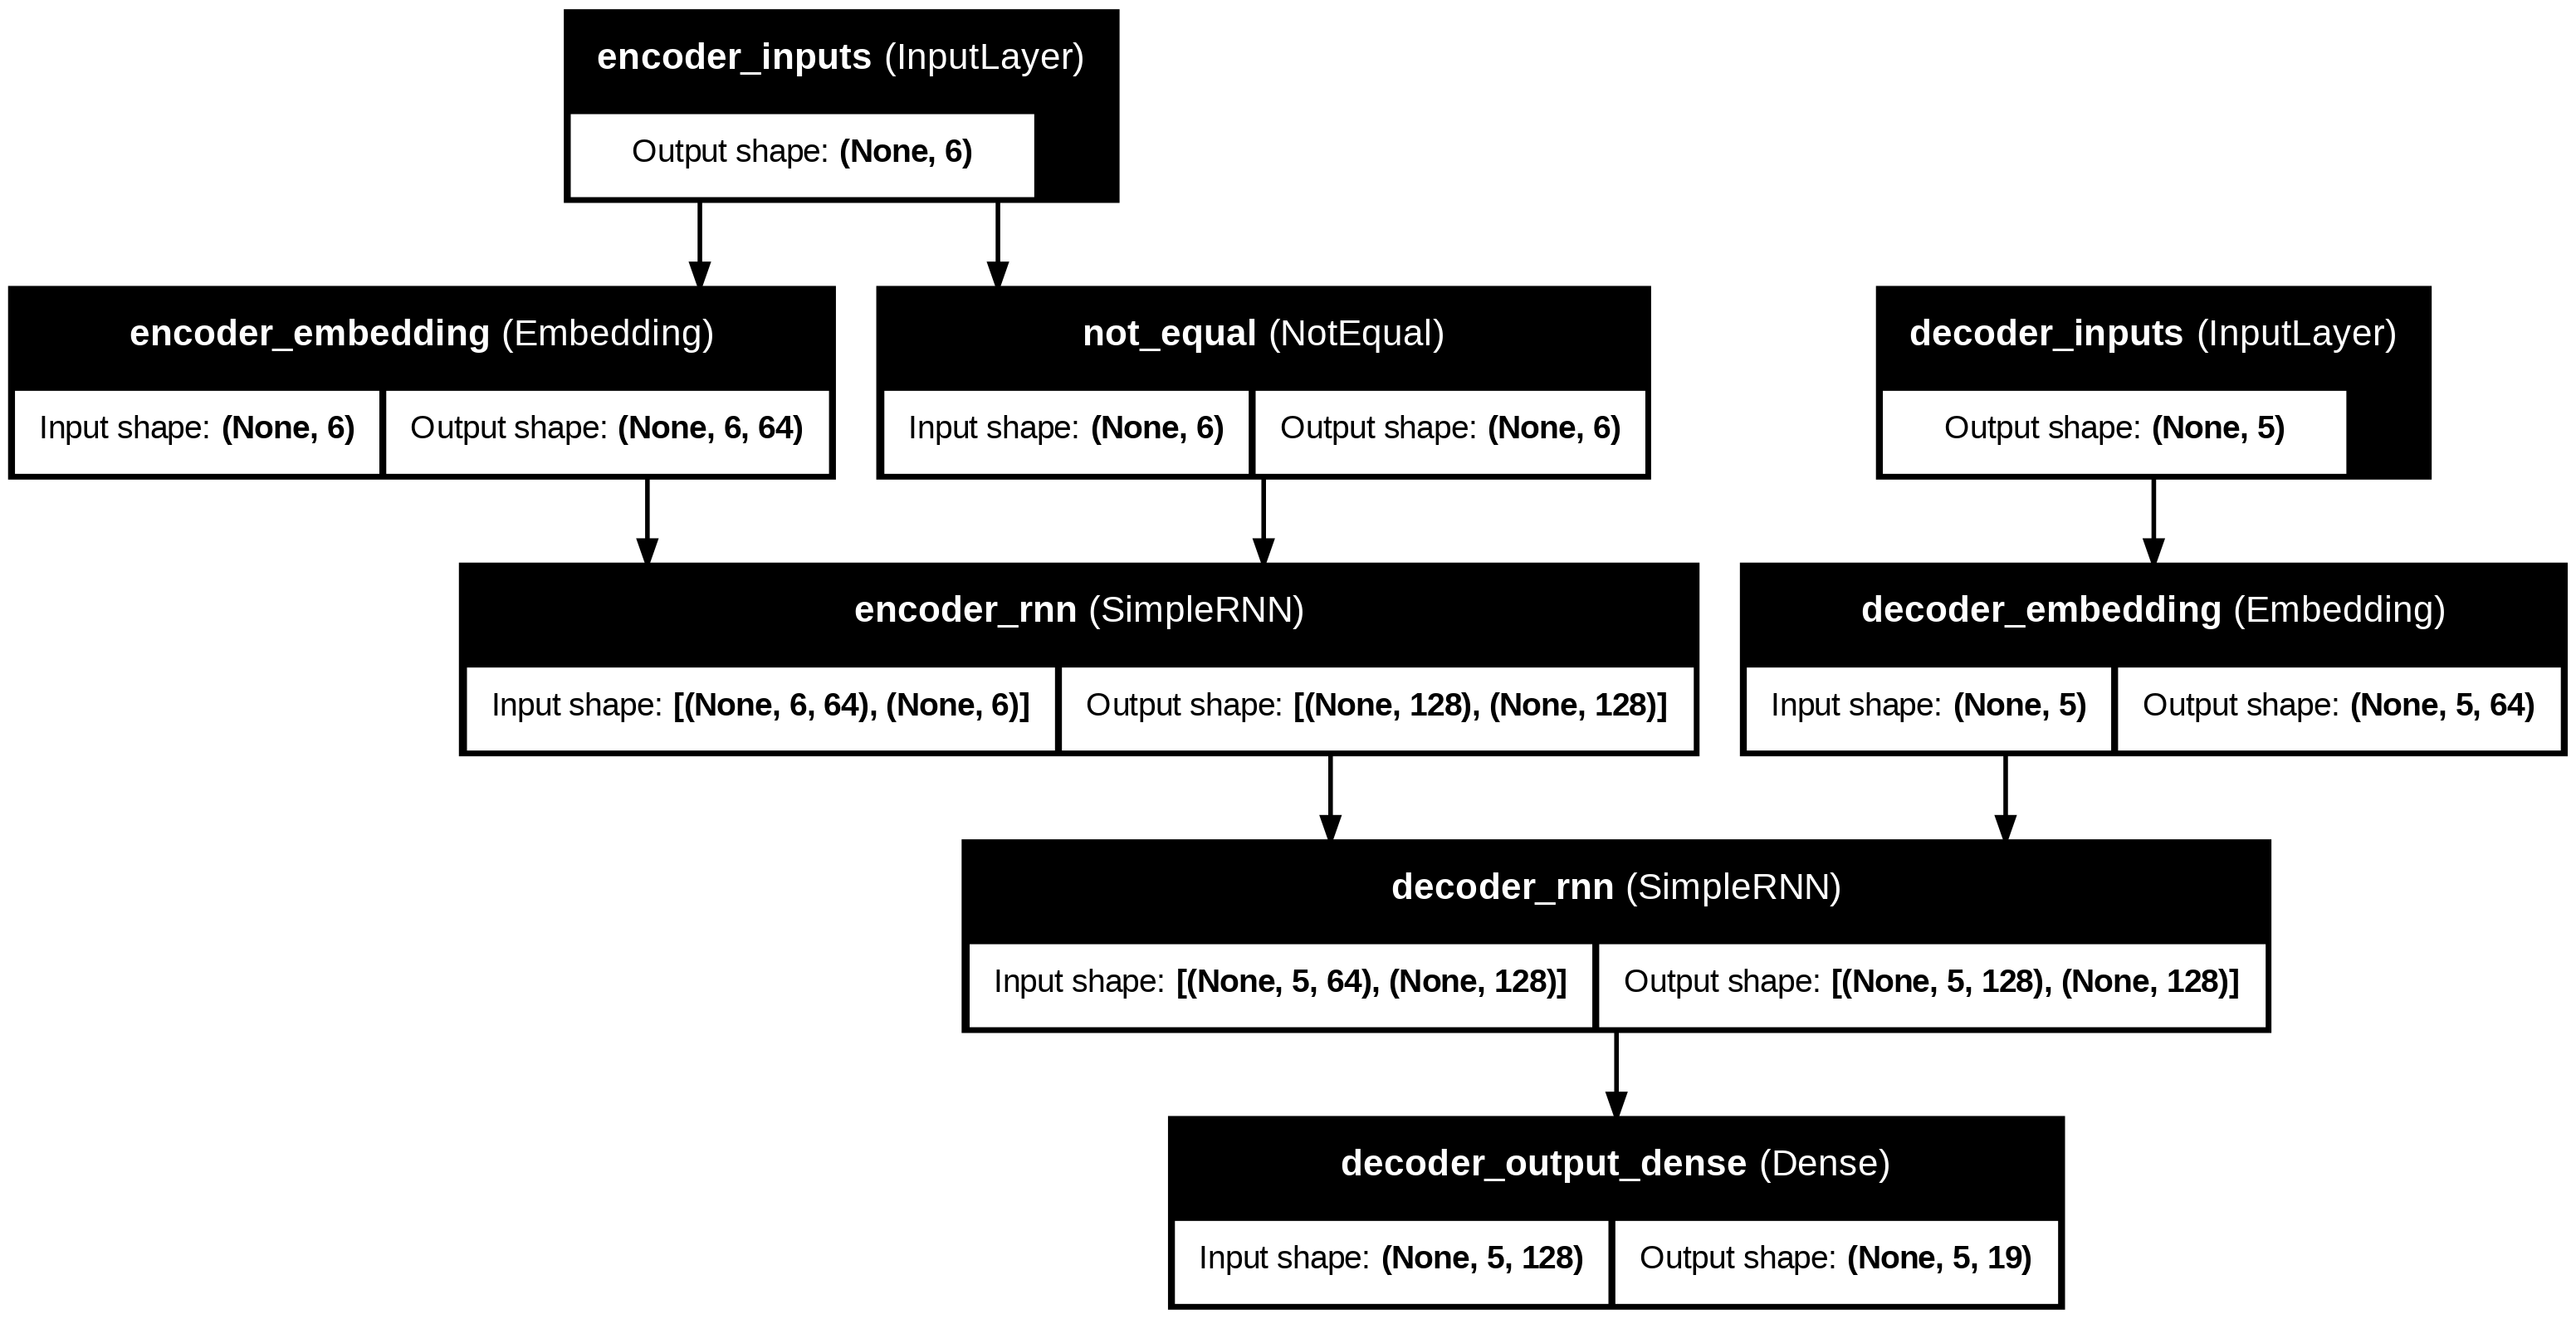

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    nmt_model,
    to_file="rnn_seq2seq.png",
    show_shapes=True,
    show_layer_names=True,
)

The diagram shows:
* an **encoder branch**, starting from `encoder_inputs`, passing through `encoder_embedding` and `encoder_rnn`, which produces the final hidden state;
* a **decoder branch**, starting from `decoder_inputs`, passing through `decoder_embedding` and  `decoder_rnn`;
* the encoder's final state is used as the initial state of the decoder RNN, so the decoder is conditioned on the source sentence;
* a final `Dense` layer with softmax, which maps each decoder hidden state to a distribution over the target vocabulary.

Compared with the language model diagram, the main difference is the presence of two separate input branches (source and target) and the explicit connection from the encoder’s final state into the decoder.

###Training the Seq2Seq Model

Training proceeds similarly to the recurrent language model, except that the decoder is now conditioned on the encoder state. On this small corpus the model will overfit quickly, but this is fine for illustration.

In [ ]:
history = nmt_model.fit(
    [src_sequences_padded, decoder_input_data],
    decoder_target_data,
    batch_size=16,
    epochs=20,
    verbose=1
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0500 - loss: 2.9439
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7500 - loss: 2.0006
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6833 - loss: 1.0520
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6833 - loss: 0.8201
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7500 - loss: 0.6462
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6500 - loss: 0.6351
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7167 - loss: 0.5609
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7833 - loss: 0.5058
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8333 - loss: 0.4130
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8833 - loss: 0.3502
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8667 - loss: 0.2910
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9167 - loss: 0.2381
Epo

* `[src_sequences_padded, decoder_input_data]`: These are the inputs to the model:
  * `src_sequences_padded`: the source sentences, converted to word IDs and padded to a fixed length.
  * `decoder_input_data`: the target sentences shifted to the right (starting with `<sos>`), used to guide the decoder during training.
* `decoder_target_data`: This is the expected output of the model:
  * the correct next target word at each position
  * typically the same target sentence, shifted to the left (ending with <eos>)
* `batch_size=16`: The model processes 16 sentence pairs at a time before updating itself. Using batches makes training faster and more stable.
* `epochs=20`: The model goes through the entire training dataset 20 times. Each pass gives the model another opportunity to improve its translations.
* `verbose=1`: This option controls how much information is printed during training. With `verbose=1`, the model shows a progress bar and training statistics after each epoch.

At each training step, the model:
* reads a batch of source sentences,
* generates predictions for the next target words,
* compares its predictions with the correct translations,
* slightly adjusts its internal parameters to reduce future errors.

The returned object history stores information about the training process, such as how the loss and accuracy change over time. This information can later be used to create learning curves and analyse training behaviour.

###Inference: Using the model to translate
During training, the model learns to translate by seeing complete sentence pairs. The decoder is helped by teacher forcing: instead of having to guess its own previous output, it is always given the correct previous target token. This makes learning faster and more stable.

During translation, however, the situation is different. The correct target sentence is unknown, so the decoder can no longer be helped in this way. It must generate the translation one token at a time, using its own previous predictions as input. For this reason, we need slightly different versions of the encoder and decoder for inference, even though they reuse the same learned
weights.

### Building Inference Models

####Encoder inference model
At translation time, the encoder still reads the entire source sentence,
just as it does during training. The difference is that its output is now computed once, stored, and then reused while the decoder generates the translation word by word. For this reason, the encoder must be available as a separate model whose final hidden state can be passed explicitly to the decoder.

We therefore build an encoder inference model that takes a source sentence as input and returns its final hidden state:

In [ ]:
encoder_model = keras.Model(
    encoder_inputs,
    encoder_state,
    name="encoder_inference"
)

This model uses the same encoder parameters as during training, but its output is now made explicit so that it can be reused during decoding.

####Decoder inference model

The decoder behaves very differently during inference than during
training. Instead of receiving the full target sentence, it now works step by step.

At each step, the decoder:
* receives a single token (the previously generated word),
* receives the previous hidden state,
* predicts the next word,
* updates its hidden state.

To make this possible, we define a decoder inference model that explicitly takes both the current token and the current hidden state as input, and returns both the predicted next-token probabilities and the updated hidden state:

In [ ]:
decoder_state_input = keras.Input(
    shape=(hidden_size,), name="decoder_state_input"
)
decoder_single_input = keras.Input(
    shape=(1,), dtype="int32", name="decoder_single_input"
)

decoder_single_embedded = decoder_embedding(decoder_single_input)

decoder_single_output, decoder_state_output = decoder_rnn(
    decoder_single_embedded,
    initial_state=decoder_state_input
)

decoder_single_probs = decoder_dense(decoder_single_output)

decoder_model = keras.Model(
    [decoder_single_input, decoder_state_input],
    [decoder_single_probs, decoder_state_output]
)

This decoder behaves like a manually unrolled RNN language model.

###Translation -- Decoding
Finally, we define a simple decoding function. It encodes the source sentence, then repeatedly calls the decoder to produce the next target word, stopping when `<eos>` is generated.

**Goal of `translate_rnn()`**. This function translates a single source sentence by running the encoder once and then generating the target sentence word-by-word with the decoder.
This is necessary at inference time because we do not know the correct target words in advance (so we cannot use teacher forcing).


In [ ]:
def translate_rnn(sentence, max_len=10):
    # 1. Preprocess the source sentence.
    # • We add explicit start/end markers to the source sentence: <sos> (start of sentence)
    #   and <eos> (end of sentence).
    # • We lowercase the sentence (sentence.lower()) to match the training preprocessing
    # (if the model was trained on lowercase text).
    # • We convert the text into integer token IDs using the tokenizer_src.
    src_text = f"<sos> {sentence.lower()} <eos>"
    seq = tokenizer_src.texts_to_sequences([src_text])[0]

    # 2. Pad the source sequence to a fixed length. Neural models typically expect
    # inputs of the same length within a batch. Even though we translate one sentence
    # here, we still pad it to max_src_len (the length used during training),
    # adding padding tokens at the end (padding="post")
    seq = pad_sequences([seq], maxlen=max_src_len, padding="post")

    # 3. Encode the source sentence (run the encoder once).
    # • The encoder reads the entire padded source sequence.
    # • It outputs a single hidden state vector, which summarises the source sentence.
    # • This hidden state will be used to initialise the decoder.
    state = encoder_model.predict(seq, verbose=0)

    # 4. Initialise decoding with <sos>.
    # • Decoding must start somewhere. We begin with the special start token <sos>.
    # • target_id stores the current token ID that will be fed into the decoder.
    # • decoded will store the generated target words.
    target_id = sos_id
    decoded = []

    # 5. Generate tokens one-by-one (autoregressive decoding). We repeat the
    #    decoding step up to max_len times to avoid infinite loops (for example,
    #    if the model never produces <eos>).
    for _ in range(max_len):

        # a) Prepare the decoder input token. The decoder expects a sequence
        #    of length 1 (one token), so we wrap target_id as a (1,1) NumPy array.
        token_seq = np.array([[target_id]])

        # b) Run one decoder step. Conceptually, a decoder conditions on the
        #    entire previously generated target sequence. In this implementation,
        #    that history is stored in the hidden state, so the decoder only
        #    needs to receive the most recent token at each step.
        # • The decoder receives:
        #   • the current token (token_seq), and
        #   • the current hidden state (state).
        # • It returns:
        #   • probs: a probability distribution over the target vocabulary for
        #     the next token, and
        #   • an updated hidden state (also stored back into state).
        probs, state = decoder_model.predict([token_seq, state], verbose=0)

        # c) Choose the most likely next token.
        # • probs[0,0,:] is the vocabulary-sized vector of probabilities for the
        #   next token. probs has three dimensions: batch size (here: 1 sentence),
        #   time steps (here: 1 token) and vocabulary (one probability per target word).
        # • np.argmax(...) selects the token ID with the highest probability.
        #   (This is greedy decoding.)
        # • We overwrite target_id with this newly predicted token, because it will be fed
        #   back into the decoder at the next step
        target_id = np.argmax(probs[0, 0, :])

        # d) Stop if we predict <eos>.
        # • If the predicted token is the end-of-sentence symbol, we stop decoding.
        if target_id == eos_id:
            break
        # Otherwise we convert the predicted ID back to a word and append it to
        # the output list.
        decoded.append(tgt_index_word[target_id])

    # 6. Return the final translation as text.
    # • decoded is a list of words.
    # • We join them with spaces to form a sentence-like string.
    return " ".join(decoded)

This completes a minimal recurrent encoder–decoder translation system, matching the architecture of the earliest neural machine translation models.

###Example Translations (End-to-End)
To illustrate how the model performs translation at inference time, we now walk through complete examples using the `translate_rnn` function defined in Step 12. The process mirrors the behaviour of the recurrent language model but conditions the decoder on the encoder's final state.

**Example 1: Translating “she likes apples”**

 We begin by passing the English sentence to our translation

In [ ]:
print(translate_rnn("she likes apples"))

zij lust appels


This result reflects patterns learned from the Dutch side of the corpus. Let us break down the steps of the inference procedure.

The sentence is first wrapped in `<sos>` and `<eos>`:
`<sos> she likes apples <eos>`
and converted into its integer sequence. After padding we obtain:

In [ ]:
src_text = "<sos> she likes apples <eos>"
print(tokenizer_src.texts_to_sequences([src_text]))

[[1, 11, 15, 5, 2]]


This padded sequence is then passed to the encoder:


In [ ]:
state = encoder_model.predict(
pad_sequences(tokenizer_src.texts_to_sequences([src_text]),
              maxlen=max_src_len,
              padding="post"
          ),
          verbose=0
)
print("Encoder state shape:", state.shape)

Encoder state shape: (1, 128)


The vector `state` is a dense summary of the entire source sentence and initialises the decoder.


In [ ]:
print(state)

[[-0.22236374 -0.8094996  -0.81891036 -0.9713968   0.99053735 -0.92785376
  -0.9035504  -0.8304576   0.732412    0.8621592   0.607656   -0.82293105
  -0.95310056  0.57844293  0.694971    0.98181355 -0.2093468   0.9724542
   0.47125205 -0.9129261  -0.8808723   0.69946384  0.7156927   0.16121942
   0.9192083   0.9875917   0.9166717   0.57287806 -0.9983552  -0.5619349
   0.2011652   0.9223058  -0.81799424 -0.8703621   0.91656363  0.7184327
   0.0391465   0.6184588  -0.97509634  0.79034215 -0.9789292   0.8654603
  -0.9083952  -0.95054567 -0.9002706  -0.3817914  -0.7860469   0.33066016
   0.78677267 -0.08796768  0.9071892  -0.3908287   0.94643253 -0.9985159
  -0.43917423  0.9983923   0.96256274  0.9867426   0.9295079   0.94248456
   0.9993321   0.97289616 -0.41668898  0.9491715  -0.5613649  -0.9493155
   0.9380726  -0.9869439  -0.7303377  -0.06717695 -0.8197591   0.88154703
   0.9035218  -0.791154   -0.959261    0.98752594 -0.4888158   0.7732178
  -0.8703483   0.79953045  0.8593425   0.2585

We begin decoding with the token <sos>:

In [ ]:
token = sos_id
token_seq = np.array([[token]])
probs, next_state = decoder_model.predict([token_seq, state], verbose=0)

predicted_id = np.argmax(probs[0, 0, :])
print("First predicted token:", tgt_index_word[predicted_id])

First predicted token: zij


This produces `zij`, reflecting that Dutch sentences for this corpus often begin with the subject pronoun.

At each following step, we feed the previous output token and the updated
hidden state:

In [ ]:
decoded = []
state_now = next_state
current_token = predicted_id

for _ in range(5):
    token_seq = np.array([[current_token]])
    probs, state_now = decoder_model.predict([token_seq, state_now], verbose=0)
    current_token = np.argmax(probs[0,0,:])

    if current_token == eos_id:
        break

    decoded.append(tgt_index_word[current_token])

print("Decoded continuation:", decoded)

Decoded continuation: ['lust', 'appels']


**Example 2 and 3**



In [ ]:
print(translate_rnn("i am a student"))

ik ben een student


In [ ]:
print(translate_rnn("you like apples"))

jij lust appels


# Scaling up

For scaling up there is a separate Google Colab session: https://colab.research.google.com/drive/1c8MaNFhNdzfwAzPx5Xd9SZjHWgTD0fsx?usp=sharing